<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/code/SD/SD_fcn_lonlatcov_11_1_15s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dive Prediction - Deep Network

*Predicting Seabird Diving Behaviour from GPS data*

This notebook trains a neural network to predict seabirds' dives.

Networks' characteristics:

* *Trajectory window* : 60 x 5s
* *Output resolution*: 60 x 5s
* *Representation of trajectories* : Matrix Distance and Time series
* *Layers* : convolutions

## connect to drive

In [40]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [41]:
%cd drive/My\ Drive/

[Errno 2] No such file or directory: 'drive/My Drive/'
/content/drive/My Drive


## load data

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils.trip import * 

In [43]:
data_train = pd.read_csv('./data/SD_train.csv')
data_test = pd.read_csv('./data/SD_test.csv')

In [44]:
data_train = standardize_data(data_train)
data_test = standardize_data(data_test)

data_train.head()

,datetime,trip,lon,lat,step_speed,step_direction,gaps,pressure,dive,lon_std,lat_std,step_speed_std,step_direction_cos,step_direction_sin
0,2017-04-25 14:23:25,F0417_11_SD_T1,-32.388702,-3.816197,14.415879,-75.239695,0.0,-1.07,0,-2.059077,1.297701,0.705006,0.254776,-0.967000
1,2017-04-25 14:23:40,F0417_11_SD_T1,-32.387295,-3.815108,13.184866,39.620556,0.0,-1.07,0,-2.045569,1.320049,0.644804,0.770285,0.637700
2,2017-04-25 14:23:55,F0417_11_SD_T1,-32.386070,-3.814450,10.301176,9.505804,0.0,-1.07,0,-2.033807,1.333552,0.503777,0.986269,0.165148
3,2017-04-25 14:24:10,F0417_11_SD_T1,-32.384834,-3.814002,9.736954,8.330893,0.0,-1.13,0,-2.021940,1.342745,0.476184,0.989448,0.144890
4,2017-04-25 14:24:25,F0417_11_SD_T1,-32.382969,-3.813600,14.127733,7.774125,0.0,-1.13,0,-2.004034,1.350995,0.690914,0.990809,0.135268


## No fine-tuning

In [62]:
# hyperparameters
batch_size = 64
window = 21
variable = ('lon_std', 'lat_std', 'gaps')

## reduce size dataset
train_set = TrajDataSet(data_train, window, variable, transform = transforms.Compose([Center(), ToTensor()]))
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)

In [63]:
class FCNet(nn.Module):

    def __init__(self):
        super(FCNet, self).__init__()

        self.cnn = nn.Sequential(
            nn.Linear(3*21,100),
            nn.ReLU(),
            nn.Linear(100,500),
            nn.ReLU(),
            nn.Linear(500,500),
            nn.ReLU(),
            nn.Linear(500,500),
            nn.ReLU(),
            nn.Linear(500,1)
        )

    def forward(self, x):
        out = x.reshape((x.size()[0], 1, 3*21))
        out = self.cnn(out)
        return out

def get_score(out, y):
    out, y = out.cpu(), y.cpu()
    out = 1*(out>0)
    true_positive = np.mean(out[y == True].numpy()) 
    true_negative = 1-np.mean(out[y == False].numpy())
    
    return (round(true_positive*100) , round(true_negative*100))

In [64]:
model = torch.load('./SV_fcn_lonlatcov_15s.pt')

In [65]:
dive_estim = []

for i in data_test.trip.unique():
    # create dataset for a trajectory
    t = data_test[data_test.trip == i].copy()    
    test_set = TrajDataSet(t, window, variable, transform = transforms.Compose([Center(), ToTensor()]))

    model.eval()
    estim = [0 for i in range(10)]
    k = 0
    with torch.no_grad():
        for (x, y, z) in test_set:

            # Run the forward pass
            out = model(x)
            estim.append(out.cpu().squeeze().numpy())

    estim = estim + [0 for i in range(10)]
    dive_estim.append(estim)
    print(i)

data_test['prediction'] = 1/(1+np.exp(-np.hstack(dive_estim)))

F0417_10_SD_T1
F0417_16_SD_T1
F0417_16_SD_T2
F0417_17_SD_T1
F0417_17_SD_T2
F0417_24_SD_T2
F0417_24_SD_T4
F0417_5_SD_T1
F0418_11_SD_T2
F0418_11_SD_T3
F0418_14_SD_T2
F0418_23_SD_T1
F0418_23_SD_T2
F0418_24_SD_T1
F0418_24_SD_T2
F0418_25_SD_T2
F0418_26_SD_T1
F0418_30_SD_T3
F0419_1_SD_T2
F0419_1_SD_T3
F0419_3_SD_T1
F0419_3_SD_T5
F0419_4_SD_T1
F0419_7_SD_T1
F0419_7_SD_T2
F0419_8_SD_T1
F0419_9_SD_T1
F0419_9_SD_T3


0.3714020773734134

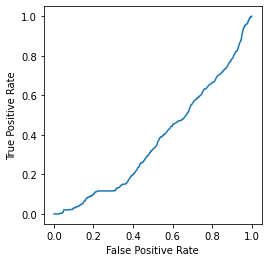

In [66]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# globally
TP = []
FP = []

for tt in np.arange(0,1,0.001):
    all_estim = 1* (data_test.prediction > tt)
    true_positive = np.mean(all_estim[data_test.dive == 1])
    true_negative = 1-np.mean(all_estim[data_test.dive == 0])
    TP.append(true_positive)
    FP.append(1-true_negative)

plt.plot(np.array(FP), np.array(TP))
-np.trapz(TP, FP)

# Fine-tuning

In [67]:
# Loss and score
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
weight = torch.FloatTensor([50])
criterion = nn.BCEWithLogitsLoss(pos_weight = weight)

In [69]:
# Train the model
nb_epoch = 1

global_loss_train = []

for epoch in range(nb_epoch):
    i = 0
    for batch, (x, y, z) in enumerate(train_loader):
        i+=1

        # Run the forward pass
        out =  model(x)
        loss = criterion(out, z)
        
        # Backprop and perform optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    ### Evaluation + Validation every epoch
    model.eval()
    with torch.no_grad():      
        j = 0
        # evaluation
        list_loss_train = []
        list_score_train = []
        for batch, (x, y, z) in enumerate(train_loader):
            j+= 1

            # Run the forward pass
            out =  model(x)
            loss = criterion(out, z)
            list_loss_train.append(loss.item())
        
        train_loss = np.mean(list_loss_train)

    print('Epoch [{}/{}] -------------------------------------------------------------------------------------'
          .format(epoch+1, nb_epoch))
    print('Train Loss: {}'.format(round(train_loss, 2)))
    model.train()
    
    global_loss_train.append(train_loss)


Epoch [1/1] -------------------------------------------------------------------------------------
Train Loss: 0.94


In [71]:
dive_estim = []

for i in data_test.trip.unique():
    # create dataset for a trajectory
    t = data_test[data_test.trip == i].copy()    
    test_set = TrajDataSet(t, window, variable, transform = transforms.Compose([Center(), ToTensor()]))

    model.eval()
    estim = [0 for i in range(10)]
    k = 0
    with torch.no_grad():
        for (x, y, z) in test_set:

            # Run the forward pass
            out = model(x)
            estim.append(out.cpu().squeeze().numpy())

    estim = estim + [0 for i in range(10)]
    dive_estim.append(estim)
    print(i)

data_test['prediction'] = 1/(1+np.exp(-np.hstack(dive_estim)))

F0417_10_SD_T1
F0417_16_SD_T1
F0417_16_SD_T2
F0417_17_SD_T1
F0417_17_SD_T2
F0417_24_SD_T2
F0417_24_SD_T4
F0417_5_SD_T1
F0418_11_SD_T2
F0418_11_SD_T3
F0418_14_SD_T2
F0418_23_SD_T1
F0418_23_SD_T2
F0418_24_SD_T1
F0418_24_SD_T2
F0418_25_SD_T2
F0418_26_SD_T1
F0418_30_SD_T3
F0419_1_SD_T2
F0419_1_SD_T3
F0419_3_SD_T1
F0419_3_SD_T5
F0419_4_SD_T1
F0419_7_SD_T1
F0419_7_SD_T2
F0419_8_SD_T1
F0419_9_SD_T1
F0419_9_SD_T3


0.6425290821436147

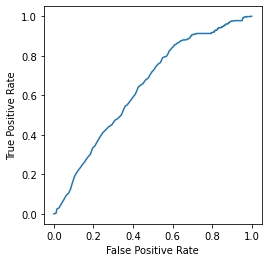

In [72]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# globally
TP = []
FP = []

for tt in np.arange(0,1,0.001):
    all_estim = 1* (data_test.prediction > tt)
    true_positive = np.mean(all_estim[data_test.dive == 1])
    true_negative = 1-np.mean(all_estim[data_test.dive == 0])
    TP.append(true_positive)
    FP.append(1-true_negative)

plt.plot(np.array(FP), np.array(TP))
-np.trapz(TP, FP)

In [73]:
torch.save(model, './SD_fcn_lonlatcov_15s.pt')
data_test.to_csv('SD_fcn_lonlatcov_15s.csv', index = False)

# from scratch

In [74]:
model = FCNet()

In [75]:
# Train the model
nb_epoch = 1

global_loss_train = []

for epoch in range(nb_epoch):
    i = 0
    for batch, (x, y, z) in enumerate(train_loader):
        i+=1

        # Run the forward pass
        out =  model(x)
        loss = criterion(out, z)
        
        # Backprop and perform optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    ### Evaluation + Validation every epoch
    model.eval()
    with torch.no_grad():      
        j = 0
        # evaluation
        list_loss_train = []
        list_score_train = []
        for batch, (x, y, z) in enumerate(train_loader):
            j+= 1

            # Run the forward pass
            out =  model(x)
            loss = criterion(out, z)
            list_loss_train.append(loss.item())
        
        train_loss = np.mean(list_loss_train)

    print('Epoch [{}/{}] -------------------------------------------------------------------------------------'
          .format(epoch+1, nb_epoch))
    print('Train Loss: {}'.format(round(train_loss, 2)))
    model.train()
    
    global_loss_train.append(train_loss)


Epoch [1/1] -------------------------------------------------------------------------------------
Train Loss: 1.06


In [76]:
dive_estim = []

for i in data_test.trip.unique():
    # create dataset for a trajectory
    t = data_test[data_test.trip == i].copy()    
    test_set = TrajDataSet(t, window, variable, transform = transforms.Compose([Center(), ToTensor()]))

    model.eval()
    estim = [0 for i in range(10)]
    k = 0
    with torch.no_grad():
        for (x, y, z) in test_set:

            # Run the forward pass
            out = model(x)
            estim.append(out.cpu().squeeze().numpy())

    estim = estim + [0 for i in range(10)]
    dive_estim.append(estim)
    print(i)

data_test['prediction'] = 1/(1+np.exp(-np.hstack(dive_estim)))

F0417_10_SD_T1
F0417_16_SD_T1
F0417_16_SD_T2
F0417_17_SD_T1
F0417_17_SD_T2
F0417_24_SD_T2
F0417_24_SD_T4
F0417_5_SD_T1
F0418_11_SD_T2
F0418_11_SD_T3
F0418_14_SD_T2
F0418_23_SD_T1
F0418_23_SD_T2
F0418_24_SD_T1
F0418_24_SD_T2
F0418_25_SD_T2
F0418_26_SD_T1
F0418_30_SD_T3
F0419_1_SD_T2
F0419_1_SD_T3
F0419_3_SD_T1
F0419_3_SD_T5
F0419_4_SD_T1
F0419_7_SD_T1
F0419_7_SD_T2
F0419_8_SD_T1
F0419_9_SD_T1
F0419_9_SD_T3


0.3742201354310633

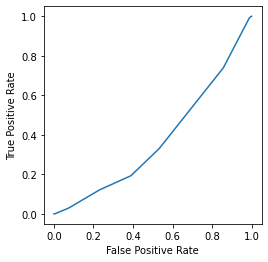

In [77]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# globally
TP = []
FP = []

for tt in np.arange(0,1,0.001):
    all_estim = 1* (data_test.prediction > tt)
    true_positive = np.mean(all_estim[data_test.dive == 1])
    true_negative = 1-np.mean(all_estim[data_test.dive == 0])
    TP.append(true_positive)
    FP.append(1-true_negative)

plt.plot(np.array(FP), np.array(TP))
-np.trapz(TP, FP)